In [2]:
# mount the google drive path
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Colab Notebooks/DroneAg/task-2-a-unsupervised-segmentation/STEGO Implementation

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/DroneAg/task-2-a-unsupervised-segmentation/STEGO Implementation


# Prepare Google Colab Environment

In [5]:
# !git clone https://github.com/mhamilton723/STEGO.git

In [6]:
!pip install wget
!pip install torchmetrics
!pip install hydra-core
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install omegaconf
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=48e7415e9f05f2a7741280a4f92de7e9f859096a5e4991fa9e91b496a206c597
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 6.5 MB/s 
     |████████████████████████████████| 79 kB 9.2 MB/s 
     |████████████████████████████████| 117 kB 71.3 MB/s 
     |████████████████████████████████| 596 kB 58.7 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=6d156cdf6a9b3f38350ca646d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-n6ax323e
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-n6ax323e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2782170 sha256=232dd42d07c92df2d9e0ab453f794cb60fa06a17e3ae968055492f52c74fb4c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-189agjbp/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 7.8 MB/s 


# Download Pretrained Model



In [ ]:
import os
from os.path import join
os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

In [9]:
import wget
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

# Load pretrained STEGO

In [10]:
from train_segmentation import LitUnsupervisedSegmenter

model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

/content/drive/MyDrive/Colab Notebooks/DroneAg/task-2-a-unsupervised-segmentation/STEGO Implementation/STEGO/src/train_segmentation.py:386: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")


Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


# Load Image

In [16]:
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from utils import get_transform

# img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
img_url = '/content/drive/MyDrive/Colab Notebooks/Official Folder for DroneAg Challenge/Data/Rye/scout_point_image_20211114T103322000Z.jpe'
# response = requests.get(img_url)
# img = Image.open(BytesIO(response.content))
img = Image.open(img_url)
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# Query model and pass result through CRF

In [17]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

# Visualize Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


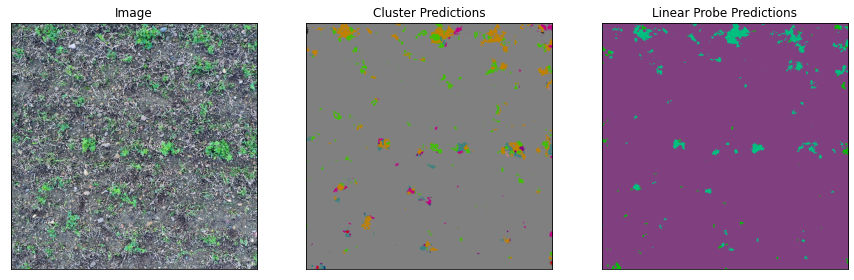

In [18]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(model.label_cmap[linear_pred])
ax[2].set_title("Linear Probe Predictions")
remove_axes(ax)